<a href="https://colab.research.google.com/github/RicardoR002/NLP-CAI2300C/blob/main/Concrete_Strength_RNN_RR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Neural Network

Ricardo Ruano CAI2300C

## Step 1: Load and Explore the Data.


The goal of this regression neural network is to develop a model to predict the (target) strength of the concrete. We used features such as cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, fine aggregate and age.


In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('https://github.com/RicardoR002/Data/raw/refs/heads/main/concrete_data.csv')

# Display the dataset
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [2]:
# Display the column names. We have our features and the target which is Strength.
print(df.columns)

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength'],
      dtype='object')


## Data report before EDA / Preprocess.

In [3]:
# We found no missing values in addition to recommendations.
def data_quality_report(df):
    report = []

    for col in df.columns:
        col_data = df[col]
        col_type = col_data.dtype
        unique_values = col_data.nunique()
        missing_values = col_data.isnull().sum()

        # Initialize problem and recommendation lists
        problems = []
        recommendations = []

        # Check for high cardinality in non-numeric columns
        if col_type == 'object' and unique_values > 50:
            problems.append("High cardinality (many unique values)")
            recommendations.append("Consider encoding with caution or reducing categories")

        # Check for missing values
        if missing_values > 0:
            problems.append(f"Missing values (count: {missing_values})")
            recommendations.append("Consider imputing missing values or removing rows")

        # For numeric columns only, check for infinities, scaling, and other issues
        if pd.api.types.is_numeric_dtype(col_data):
            # Check for infinities
            has_inf = np.isinf(col_data).sum()
            if has_inf > 0:
                problems.append(f"Infinities found (count: {has_inf})")
                recommendations.append("Consider replacing infinities with a large finite value")

            # Check if scaling is needed based on range
            col_range = col_data.max() - col_data.min()
            if col_range > 1000 or col_data.std() > 100:
                problems.append("Wide range of values")
                recommendations.append("Consider scaling (e.g., Min-Max or Standard Scaler)")

        # Check if column is non-numeric and may need encoding
        elif col_type == 'object':
            problems.append("Non-numeric column may require encoding")
            recommendations.append("Consider one-hot encoding or label encoding if needed")

        # Add column summary to report
        report.append({
            "Column": col,
            "Data Type": col_type,
            "Unique Values": unique_values,
            "Potential Problems": "; ".join(problems) if problems else "None",
            "Recommendations": "; ".join(recommendations) if recommendations else "None"
        })

    # Convert report to a DataFrame for easy viewing
    report_df = pd.DataFrame(report)
    return report_df

# Report
report_df = data_quality_report(df)
report_df

,Column,Data Type,Unique Values,Potential Problems,Recommendations
0,Cement,float64,278,Wide range of values,"Consider scaling (e.g., Min-Max or Standard Sc..."
1,Blast Furnace Slag,float64,185,None,None
2,Fly Ash,float64,156,None,None
3,Water,float64,195,None,None
4,Superplasticizer,float64,111,None,None
5,Coarse Aggregate,float64,284,None,None
6,Fine Aggregate,float64,302,None,None
7,Age,int64,14,None,None
8,Strength,float64,845,None,None


In [4]:
# Check for duplicates.
print(df.duplicated().sum())

25


In [5]:
# Dataframe of duplicates.
df[df.duplicated()]

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
77,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
80,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.40
86,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
91,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
100,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
103,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.20
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
111,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
123,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.29


In [6]:
# Drop duplicates to remove redundant rows.
df = df.drop_duplicates()

In [7]:
# Verify removal of duplicates.
print(df.duplicated().sum())

0


In [8]:
# Check data shape.
df.shape

(1005, 9)

## Analyze the target value and look for outliers.

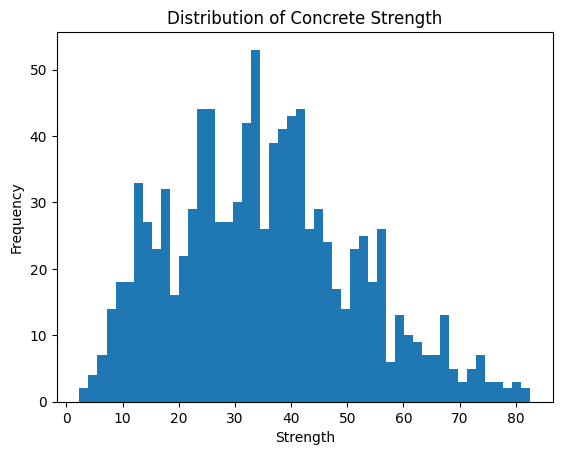

In [9]:
import matplotlib.pyplot as plt
# Visualize the distribution of the target variable (strength)
plt.hist(df['Strength'], bins=50)
plt.xlabel('Strength')
plt.ylabel('Frequency')
plt.title('Distribution of Concrete Strength')
plt.show()

## Analyze all the columns and look for outliers.


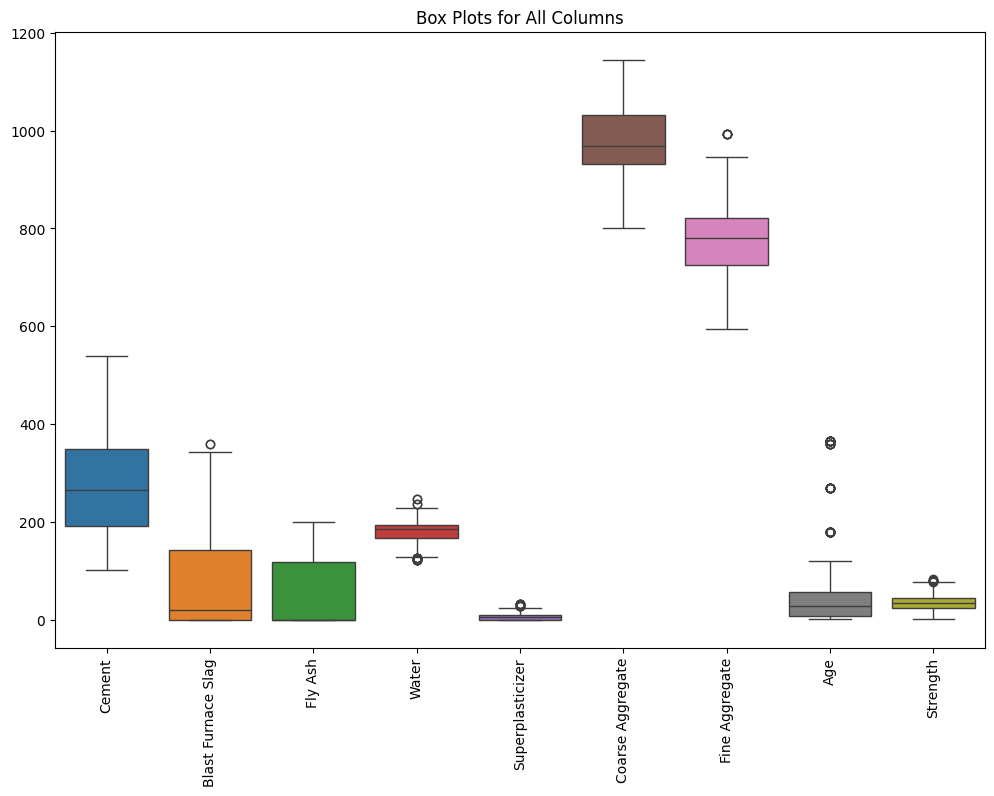

In [10]:
import seaborn as sns

# Create box plots for all columns.
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Box Plots for All Columns')
plt.show()

# We can see outliers on the box plots for Blast Furnace Slag, Water,Superplasticizer,Fine Aggregate, Age, and Strength.

<ipython-input-11-eedfc72f845f>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45.85671641791045' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  column[(column < lower_bound) | (column > upper_bound)] = column.mean()


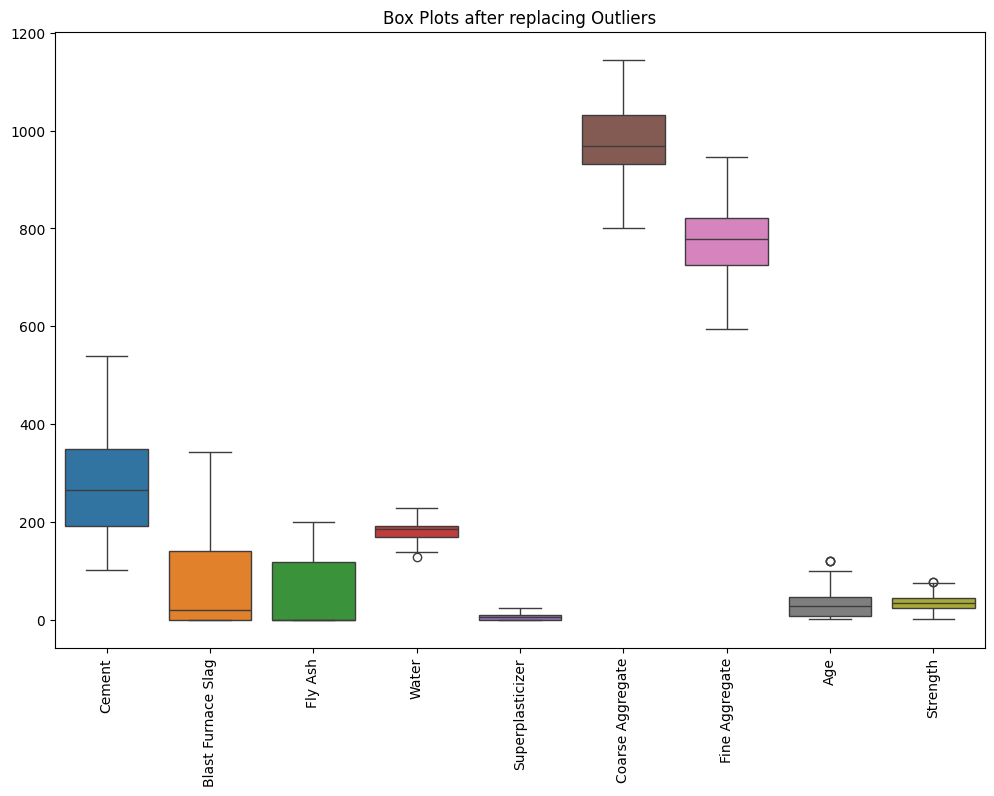

In [11]:
# Replace outliers with mean.
def replace_outliers_with_mean(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    column[(column < lower_bound) | (column > upper_bound)] = column.mean()
    return column

columns_to_replace_outliers = ['Blast Furnace Slag', 'Water', 'Superplasticizer', 'Fine Aggregate', 'Age', 'Strength']
df[columns_to_replace_outliers] = df[columns_to_replace_outliers].apply(replace_outliers_with_mean)

plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Box Plots after replacing Outliers')
plt.show()

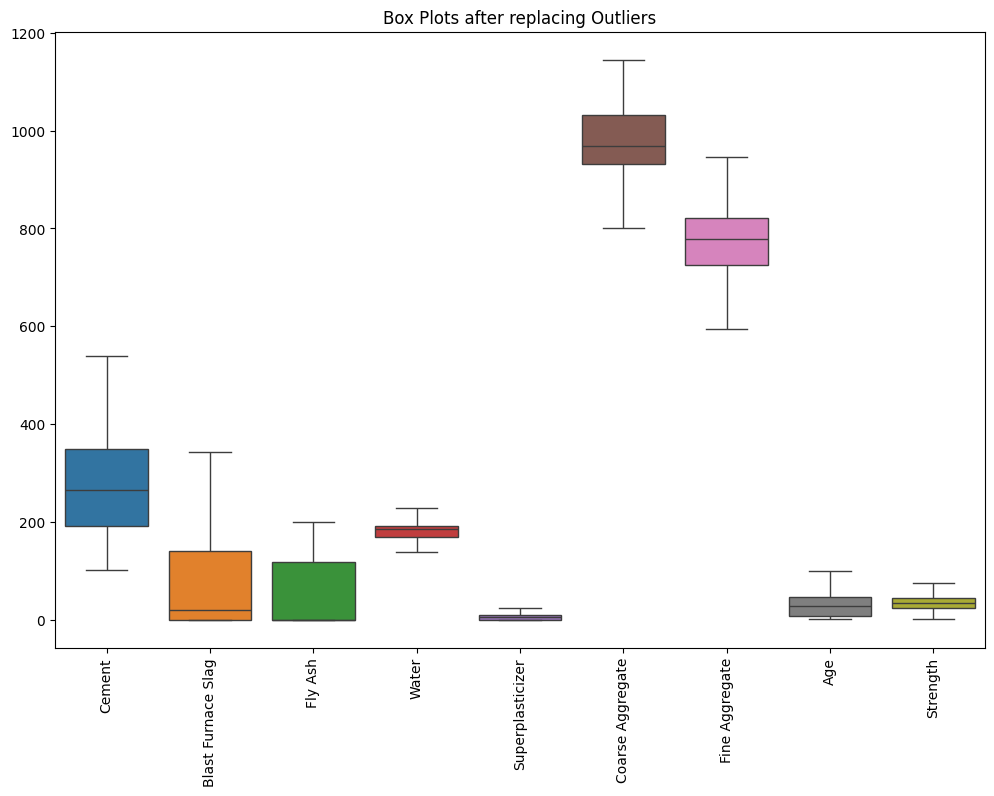

In [12]:
# We still see outliers in 3 columns, Water, Age, and Strength.
# Replace outliers with mean.

columns_to_replace_outliers = ['Water', 'Age', 'Strength']
df[columns_to_replace_outliers] = df[columns_to_replace_outliers].apply(replace_outliers_with_mean)

plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Box Plots after replacing Outliers')
plt.show()

## Step 2: Preprocessing the Data

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Handle missing values if necessary, we have none.

# Separate input features and target variable
X = df.drop(columns=['Strength'])  # Strength is the target column.
y = df['Strength'].values

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Scale the numerical features (since regression often benefits from scaling)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Check the number of features
n_features = X.shape[1]
print(f"Number of features: {n_features}")

Number of features: 8


## Step 3: Split the Data

In [14]:
from sklearn.model_selection import train_test_split

# Split into train and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Step 4: Define the Regression Model

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# Define the number of features
n_features = 8

# Define the regression model
model = Sequential([
    Input(shape=(n_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# Text summary of the model - shape neural network.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

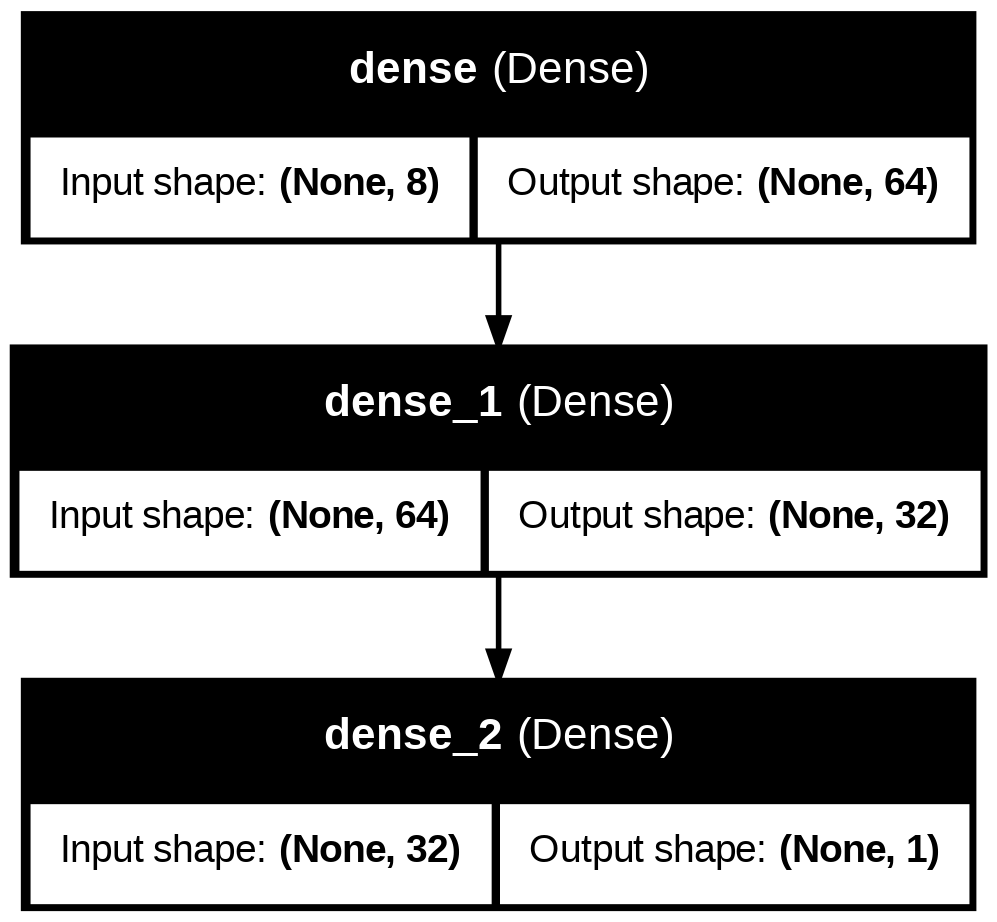

In [17]:
from tensorflow.keras.utils import plot_model

# Visual diagram of the nueral network structure.
plot_model(model, show_shapes=True, show_layer_names=True)


## Step 5: Train the Model

In [18]:
# Train the model.
model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=1)

Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1430.6647
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1312.8069  
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1177.8102 
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1064.8875  
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 727.5403 
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 446.2941  
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 279.4584
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180.4385 
Epoch 9/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 123.2499
Epoch 10/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 128.2534
Epoch 11/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 116.6306
Epoch 12/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110.5259
Epoch 13/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 111.1991
Epoch 14/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 105.0500
Epoch 15/150
22/22 ━━━━━━━━━━━

## Step 6: Evaluate the Model

In [19]:
# Evaluate the model.
loss = model.evaluate(X_test, y_test)
print('Test Mean Squared Error: %.2f' % loss)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.3900  
Test Mean Squared Error: 61.48


## Step 7: Make Predictions

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your data if not already loaded.
# df = pd.read_csv('your_data.csv')  # Uncomment and modify as needed.

# Ensure df is defined.
if 'df' not in globals():
    raise ValueError("DataFrame 'df' is not defined. Please load your data.")

# Create a sample input with all necessary features.
sample = np.array([[
    350,    # Cement (within typical range)
    100,    # Blast Furnace Slag (non-zero value, as it's often used)
    50,     # Fly Ash (moderate amount)
    180,    # Water (close to mean)
    6,      # Superplasticizer (close to mean)
    970,    # Coarse Aggregate (close to mean)
    775,    # Fine Aggregate (close to mean)
    28      # Age (common testing age)
]])

# Create a DataFrame with the correct column names.
feature_names = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water',
                 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']
sample_df = pd.DataFrame(sample, columns=feature_names)

# Prepare the data for scaling.
concrete_data = df[feature_names]  # Use only the features used in training.

# Create and fit the scaler.
scaler = StandardScaler()
scaler.fit(concrete_data)

# Scale the sample data.
sample_scaled = scaler.transform(sample_df)

# Ensure the model is defined.
if 'model' not in globals():
    raise ValueError("Model is not defined. Please load or train your model.")

# Predict the Concrete strength.
predicted_strength = model.predict(sample_scaled)

# Print the predicted strength.
print(f"Predicted Concrete Strength: {predicted_strength[0][0]:.2f} MPa")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Concrete Strength: 47.24 MPa


In [21]:
from sklearn.metrics import mean_squared_error
import math
# Calculate RMSE for model.
# y_test contains the true values and predictions contains the model's predictions.
predictions = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Root Mean Squared Error (RMSE): 7.840720263779677


In [22]:
# Calculate MSE for model.
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 61.476894254845256


In [23]:
# Calculate R2 score.
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.7520094461025385
